In [85]:
import numpy as np
from scipy import sparse as sp
from scipy.sparse.linalg import spsolve
from matplotlib import pyplot as plt
from matplotlib.ticker import IndexLocator
import time, sys
import pickle
from scipy.stats import qmc

In [86]:
# Given parameters
nx = 60
ny = 60
m=nx*ny
tf = 3.0
dt = 5.0e-3
nt = int(tf/dt)
xmin = -1; xmax = 1
ymin = -1; ymax = 1
dims=(nx,ny)

# POD basis
num_basis=np.array([3,4,5,6])
print('num_basis {}'.format(num_basis))

# parameters
p_inter=5
FOM_parameters = np.arange(75,125+1,1,dtype=int)
print("Prediction Parameters: {}".format(FOM_parameters))
print("training parameters={}".format(FOM_parameters[p_inter:-p_inter:p_inter]))

# generate mesh grid
[xv,yv]=np.meshgrid(np.linspace(xmin,xmax,nx),np.linspace(ymin,ymax,ny),indexing='xy')
x=xv.flatten()
y=yv.flatten()

# file path
file_path_gappy_DEIM_result = "./advection_result/ex9_POD_DEIM_gappy_result.p"
file_name_SVD="./advection_model/ex9_SVD.p"

# full, inner, bc index
multi_index_i,multi_index_j=np.meshgrid(np.arange(nx),np.arange(ny),indexing='xy')
full_multi_index=(multi_index_j.flatten(),multi_index_i.flatten())
x0_multi_index=(multi_index_j[:,0].flatten(),multi_index_i[:,0].flatten())
x1_multi_index=(multi_index_j[:,-1].flatten(),multi_index_i[:,-1].flatten())
y0_multi_index=(multi_index_j[0,:].flatten(),multi_index_i[0,:].flatten())
y1_multi_index=(multi_index_j[-1,:].flatten(),multi_index_i[-1,:].flatten())

dims=(ny,nx)
full_raveled_indicies=np.ravel_multi_index(full_multi_index,dims)
x0_raveled_indicies=np.ravel_multi_index(x0_multi_index,dims)
x1_raveled_indicies=np.ravel_multi_index(x1_multi_index,dims)
y0_raveled_indicies=np.ravel_multi_index(y0_multi_index,dims)
y1_raveled_indicies=np.ravel_multi_index(y1_multi_index,dims)
bc_raveled_indicies=np.unique(np.concatenate((x0_raveled_indicies,x1_raveled_indicies,
                                              y0_raveled_indicies,y1_raveled_indicies)))
inner_raveled_indicies=np.setdiff1d(full_raveled_indicies,bc_raveled_indicies)

num_basis [3 4 5 6]
Prediction Parameters: [ 75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125]
training parameters=[ 80  85  90  95 100 105 110 115 120]


# gappyPOD

In [87]:
# Jessi 알고리즘
def DEIM(phi_f, nfeval, unseen=np.array([])):
    
    ninf=np.NINF
    n,m=np.shape(phi_f)
    
    l=0
    u=np.reshape(phi_f[:,l],(n,1))
    r=np.abs(u)
    if len(unseen) >0 :
        r[unseen]=ninf
    p_temp=np.argsort(-r,axis=0,kind='stable')[:1][0]
    p=p_temp
    U=u
    
    ns=int(np.ceil((nfeval-1)/(m-1)))
    for l in range(1,m):
        u=np.reshape(phi_f[:,l],(n,1))
        for k in range(ns):
            if len(p)==nfeval:
                return p
            c=np.linalg.lstsq(U[p,:],u[p,:],rcond=None)[0]
            r=np.abs(u-U@c)
            r[p]=ninf
            if len(unseen) > 0:
                r[unseen]=ninf
            p_temp=np.argsort(-r,axis=0,kind='stable')[:1][0]
            p=np.sort(np.append(p,p_temp))
        U=np.concatenate((U,u),axis=1)
         
    return p

# of measurments: 12
[ 878  940 1042 1101 1207 1214 1274 1363 2236 2325 2498 2721]
# of measurments: 12
[  75  878  958 1101 1207 1274 1302 1363 2325 2498 2641 2721]
# of measurments: 12
[  75  878  958 1042 1101 1167 1207 1274 1302 1660 2641 2721]
# of measurments: 12
[  75  878  958 1042 1101 1167 1207 1274 1302 1660 2641 2721]


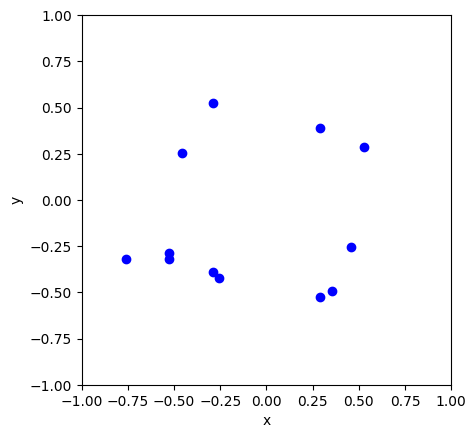

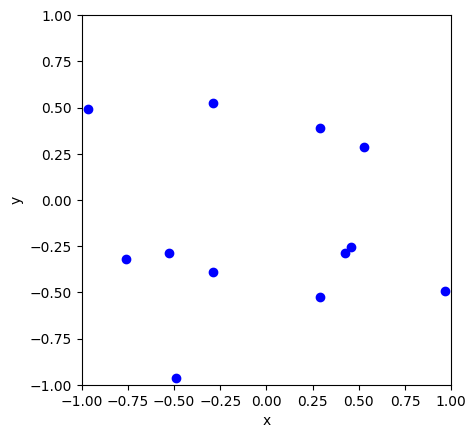

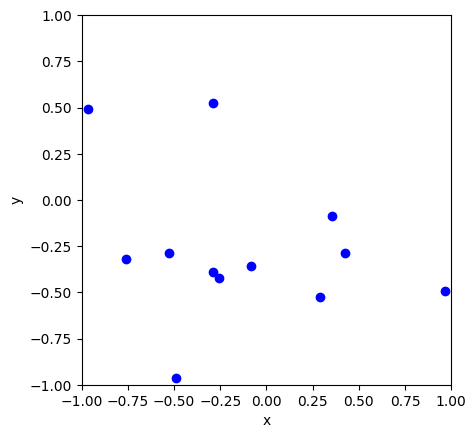

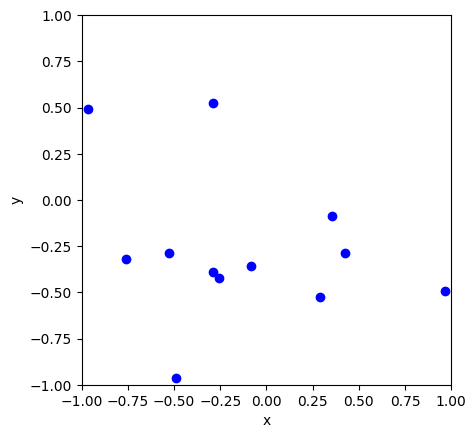

In [88]:
with open(file=file_name_SVD, mode='rb') as ff:  
    SVD = pickle.load(ff)

for ii in range(len(num_basis)):
    POD_basis=num_basis[ii]
    
    # DEIM
    num_msmt=12
    U = SVD['U']
    phi_DEIM=U[:,:POD_basis]
    msmt_idx=DEIM(phi_DEIM,num_msmt,bc_raveled_indicies)
    msmt_idx.sort()
    print("# of measurments: {}".format(len(msmt_idx)))
    print(msmt_idx)

    # plot measuremnt positions
    plt.figure()
    plt.scatter(x[msmt_idx],y[msmt_idx], color = 'blue')
    plt.axis('square')
    plt.axis([xmin,xmax,ymin,ymax])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig("./advection_result/ex9_POD_{}_DEIM_{}_samples.png".format(POD_basis,num_msmt))

# of POD basis is 3
# of measurments: 12
[ 878  940 1042 1101 1207 1214 1274 1363 2236 2325 2498 2721]
Param is 75
Time elapsed: 0.7928042411804199 sec
average relative error of u: 25.478704489485%
maximum relative error of u: 34.817371009597295%

Param is 76
Time elapsed: 1.0941047668457031 sec
average relative error of u: 25.908338274210557%
maximum relative error of u: 35.477927501590386%

Param is 77
Time elapsed: 1.0374336242675781 sec
average relative error of u: 26.337763002392496%
maximum relative error of u: 36.14083989381608%

Param is 78
Time elapsed: 0.87467360496521 sec
average relative error of u: 26.766790462447666%
maximum relative error of u: 36.805808213874876%

Param is 79
Time elapsed: 0.7965652942657471 sec
average relative error of u: 27.195216580390248%
maximum relative error of u: 37.47235413079208%

Param is 80
Time elapsed: 0.9007456302642822 sec
average relative error of u: 27.62282678711357%
maximum relative error of u: 38.14010904026991%

Param is 81
Time e

Time elapsed: 0.80373215675354 sec
average relative error of u: 15.753288802514465%
maximum relative error of u: 27.007404912319743%

Param is 80
Time elapsed: 1.0123460292816162 sec
average relative error of u: 15.862629092156338%
maximum relative error of u: 27.206243214170666%

Param is 81
Time elapsed: 0.9744000434875488 sec
average relative error of u: 15.96586815683591%
maximum relative error of u: 27.3943303657955%

Param is 82
Time elapsed: 0.9417688846588135 sec
average relative error of u: 16.062948512450355%
maximum relative error of u: 27.57147531760216%

Param is 83
Time elapsed: 1.1815366744995117 sec
average relative error of u: 16.153828117801556%
maximum relative error of u: 27.73751224714731%

Param is 84
Time elapsed: 1.2408745288848877 sec
average relative error of u: 16.23848152282753%
maximum relative error of u: 27.892294457469262%

Param is 85
Time elapsed: 1.1445164680480957 sec
average relative error of u: 16.31691237650886%
maximum relative error of u: 28.035

Time elapsed: 0.9318132400512695 sec
average relative error of u: 9.088104481576632%
maximum relative error of u: 11.368189225548047%

Param is 84
Time elapsed: 0.9226477146148682 sec
average relative error of u: 9.010588116994366%
maximum relative error of u: 11.284983478342008%

Param is 85
Time elapsed: 0.9787101745605469 sec
average relative error of u: 8.925341128087641%
maximum relative error of u: 11.192974459990559%

Param is 86
Time elapsed: 0.9900357723236084 sec
average relative error of u: 8.832608920834618%
maximum relative error of u: 11.092377905864135%

Param is 87
Time elapsed: 1.0003321170806885 sec
average relative error of u: 8.732709440489009%
maximum relative error of u: 10.983566442010565%

Param is 88
Time elapsed: 1.0371005535125732 sec
average relative error of u: 8.626038898066305%
maximum relative error of u: 10.866998316218876%

Param is 89
Time elapsed: 0.9743561744689941 sec
average relative error of u: 8.513082560885419%
maximum relative error of u: 10.7

Time elapsed: 0.8669912815093994 sec
average relative error of u: 7.850650619514048%
maximum relative error of u: 9.930970235791428%

Param is 89
Time elapsed: 0.872382640838623 sec
average relative error of u: 7.735496977386252%
maximum relative error of u: 9.79755984044987%

Param is 90
Time elapsed: 0.819838285446167 sec
average relative error of u: 7.6162155496462285%
maximum relative error of u: 9.659099968001431%

Param is 91
Time elapsed: 0.9238808155059814 sec
average relative error of u: 7.493597166398386%
maximum relative error of u: 9.516496448741895%

Param is 92
Time elapsed: 1.1217272281646729 sec
average relative error of u: 7.368550481099826%
maximum relative error of u: 9.370785977020608%

Param is 93
Time elapsed: 1.0688965320587158 sec
average relative error of u: 7.24213294928107%
maximum relative error of u: 9.22315037802538%

Param is 94
Time elapsed: 1.0779807567596436 sec
average relative error of u: 7.115551606388516%
maximum relative error of u: 9.074928494772

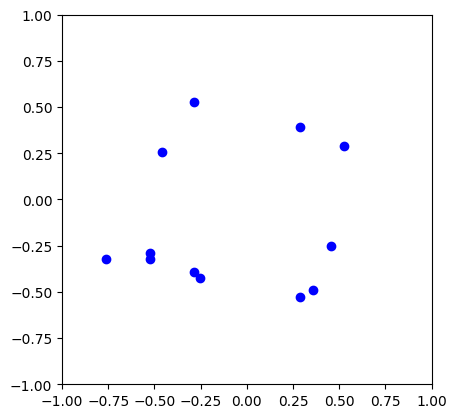

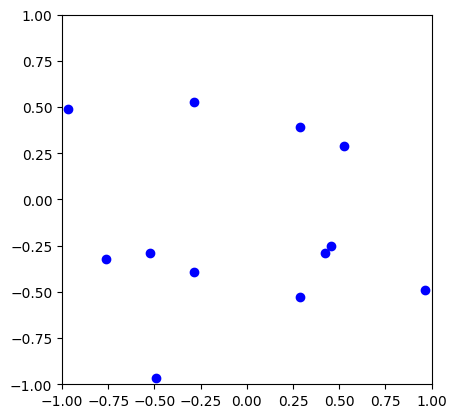

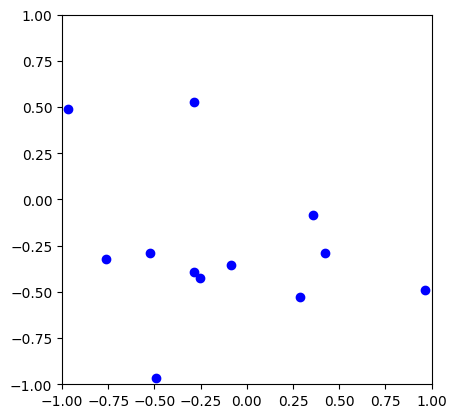

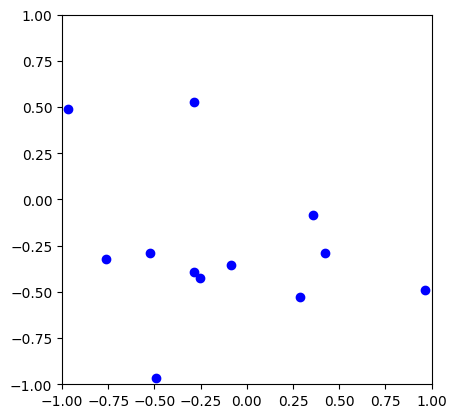

In [89]:
solution=np.zeros((len(num_basis),len(FOM_parameters),nt+1,nx*ny))
avg_rel_err=np.zeros((len(num_basis),len(FOM_parameters)))
rel_err=np.zeros((len(num_basis),len(FOM_parameters),nt+1))
elapsed_time=np.zeros((len(num_basis),len(FOM_parameters)))

with open(file=file_name_SVD, mode='rb') as ff:  
    SVD = pickle.load(ff)

for ii in range(len(num_basis)):
    POD_basis=num_basis[ii]
    print("# of POD basis is {}".format(POD_basis))
    
    # DEIM
    num_msmt=12
    U = SVD['U'];S = SVD['S']
    phi_DEIM=U[:,:POD_basis]

    msmt_idx=DEIM(phi_DEIM,num_msmt,bc_raveled_indicies)
    msmt_idx.sort()

    print("# of measurments: {}".format(len(msmt_idx)))
    print(msmt_idx)

    # plot measuremnt positions
    plt.figure()
    plt.scatter(x[msmt_idx],y[msmt_idx], color = 'blue')
    plt.axis('square')
    plt.axis([xmin,xmax,ymin,ymax])
#     plt.savefig("./advection_result/ex9_POD_{}_DEIM_{}_samples.png".format(POD_basis,num_msmt))
    
    # Basis matrix
    phi_u = SVD['U'][:,:POD_basis]

    phim_u=phi_u[msmt_idx]
    phim_u_pinv=np.linalg.pinv(phim_u)
    
    for jj in range(len(FOM_parameters)):
        FOM_parameter=FOM_parameters[jj]
        print("Param is {}".format(FOM_parameter))
        
        # Load FOM solution
        ex = np.load('./advection_data/ex9_interp_{}.npz'.format(FOM_parameter), allow_pickle = True)
        ex = ex.f.arr_0
        u_full = ex.reshape(nt+1,-1)

        # take measurments
        um = u_full[:,msmt_idx]

        # Initial condition
        u0=u_full[0]
        u_ref = u0

        # Gappy POD
        t_start_gappyPOD=time.time()

        # solution
        u_gappyPOD=np.zeros((nt+1,ny*nx))
        u_hat=np.zeros((nt+1,POD_basis))

        # IC
        u_hat0=np.zeros(POD_basis)
        u_gappyPOD[0]=np.copy(u0)

        for n in range(nt):
            u_hat[n+1] = phim_u_pinv.dot(um[n+1]-u_ref[msmt_idx])
            u_gappyPOD[n+1] = u_ref + phi_u.dot(u_hat[n+1])

        # elapsed time
        t_elapsed_gappyPOD=time.time()-t_start_gappyPOD
        print('Time elapsed: {} sec'.format(t_elapsed_gappyPOD))

        # error
        u_rel_err_gappyPOD=np.linalg.norm(u_full-u_gappyPOD,ord=2,axis=1)/np.linalg.norm(u_full,ord=2,axis=1)*100
        u_avg_rel_err=np.sqrt(np.sum(np.linalg.norm(u_full-u_gappyPOD,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(u_full,ord=2,axis=1)**2))*100
        print("average relative error of u: {}%".format(u_avg_rel_err))
        print("maximum relative error of u: {}%".format(np.max(u_rel_err_gappyPOD)))
        print()

        # save result
        solution[ii,jj]=u_gappyPOD
        avg_rel_err[ii,jj]=u_avg_rel_err
        rel_err[ii,jj]=u_rel_err_gappyPOD
        elapsed_time[ii,jj]=t_elapsed_gappyPOD
    
results={'solution':solution,'avg_rel_err':avg_rel_err,'rel_err':rel_err,'elapsed_time':elapsed_time}
with open(file=file_path_gappy_DEIM_result, mode='wb') as ff:
    pickle.dump(results, ff)

In [90]:
print(num_basis)
idx=[0,1,2,3]
num_basis[idx]

[3 4 5 6]


array([3, 4, 5, 6])

Text(0.5, 1.0, 'Max. Rel. Err. vs Parameters')

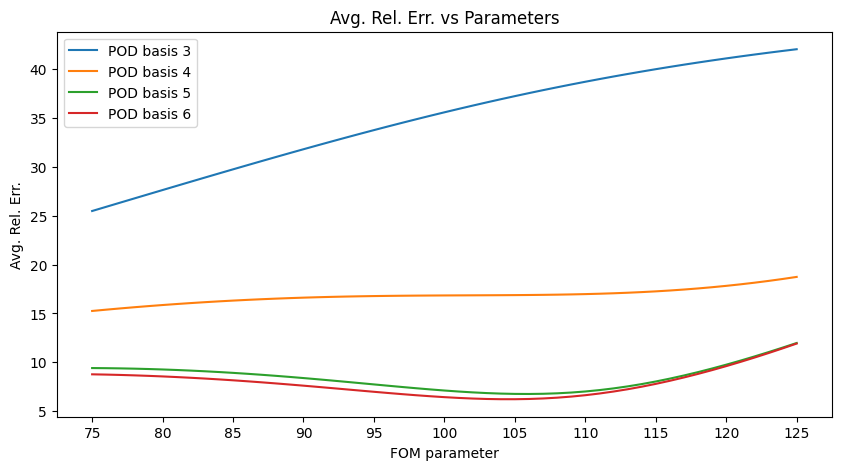

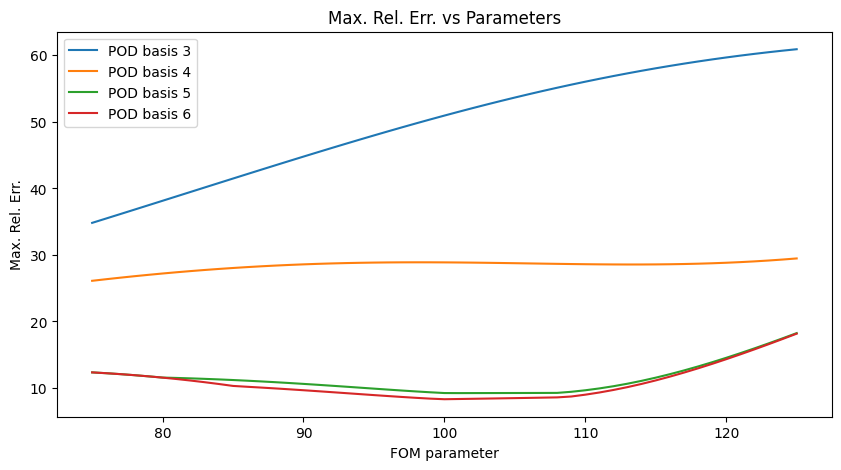

In [91]:
# with open(file=file_path_gappy_DEIM_result, mode='rb') as ff:
#     results=pickle.load(ff)    

# figure avg.rel.err vs params
plt.figure(figsize=(10,5))
for i in idx:   
    plt.plot(FOM_parameters,results['avg_rel_err'][i])
plt.xlabel('FOM parameter')
plt.ylabel('Avg. Rel. Err.')
plt.legend(["POD basis "+str(POD_basis) for POD_basis in num_basis[idx]])

ax=plt.gca()
ax.xaxis.set_major_locator(IndexLocator(p_inter,0))
ax.xaxis.set_minor_locator(IndexLocator(p_inter,p_inter))
ax.tick_params(axis='x',which='minor',labelcolor='blue',labelsize=20)
plt.title('Avg. Rel. Err. vs Parameters')
# plt.savefig("./advection_result/ex9_POD_DEIM_avg_rel_err.png")

# figure rel.err vs data points
plt.figure(figsize=(10,5))
plt_inter=1
for i in idx:   
    plt.plot(FOM_parameters,results['rel_err'][i].max(axis=1))
plt.xlabel('FOM parameter')
plt.ylabel('Max. Rel. Err.')
plt.legend(["POD basis "+str(POD_basis) for POD_basis in num_basis[idx]])
plt.title('Max. Rel. Err. vs Parameters')
# plt.savefig("./advection_result/ex9_POD_DEIM_max_rel_err.png")

In [92]:
print(num_basis)
print(FOM_parameters)

[3 4 5 6]
[ 75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125]


In [93]:
idx=[3]
num_basis[idx]

array([6])

Text(0.5, 1.0, 'Max. Rel. Err. vs Parameters')

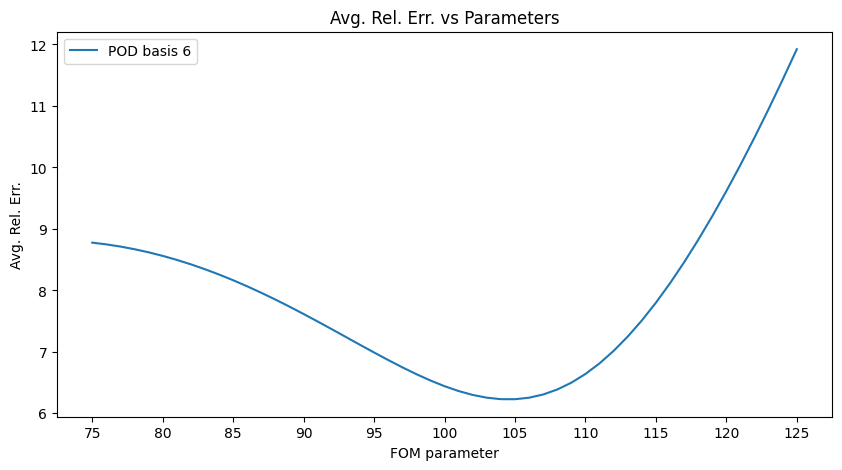

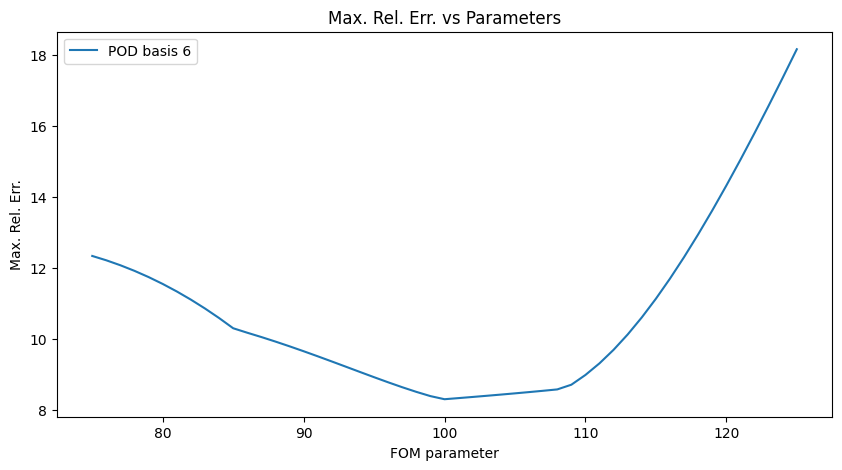

In [94]:
# with open(file=file_path_gappy_DEIM_result, mode='rb') as ff:
#     results=pickle.load(ff)    

# figure avg.rel.err vs params
plt.figure(figsize=(10,5))
for i in idx:   
    plt.plot(FOM_parameters,results['avg_rel_err'][i])
plt.xlabel('FOM parameter')
plt.ylabel('Avg. Rel. Err.')
plt.legend(["POD basis "+str(POD_basis) for POD_basis in num_basis[idx]])

ax=plt.gca()
ax.xaxis.set_major_locator(IndexLocator(p_inter,0))
ax.xaxis.set_minor_locator(IndexLocator(p_inter,p_inter))
ax.tick_params(axis='x',which='minor',labelcolor='blue',labelsize=20)
plt.title('Avg. Rel. Err. vs Parameters')
# plt.savefig("./advection_result/ex9_POD_{}_DEIM_avg_rel_err.png".format(int(num_basis[idx])))

# figure rel.err vs data points
plt.figure(figsize=(10,5))
plt_inter=1
for i in idx:   
    plt.plot(FOM_parameters,results['rel_err'][i].max(axis=1))
plt.xlabel('FOM parameter')
plt.ylabel('Max. Rel. Err.')
plt.legend(["POD basis "+str(POD_basis) for POD_basis in num_basis[idx]])
plt.title('Max. Rel. Err. vs Parameters')
# plt.savefig("./advection_result/ex9_POD_{}_DEIM_max_rel_err.png".format(int(num_basis[idx])))

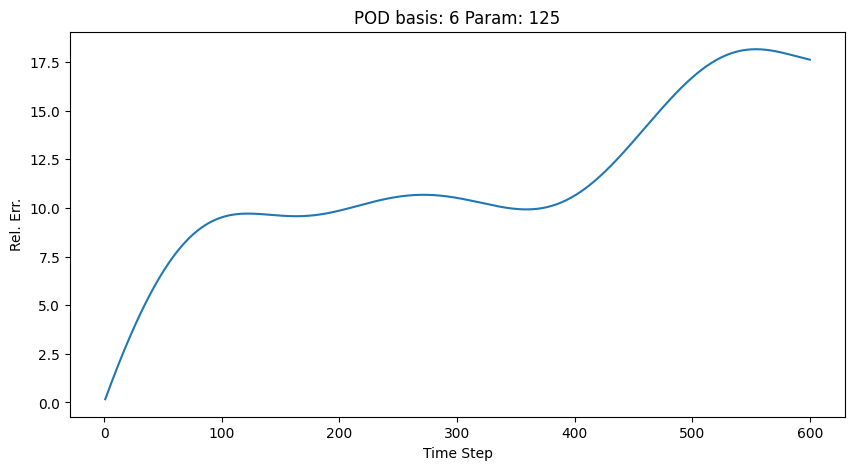

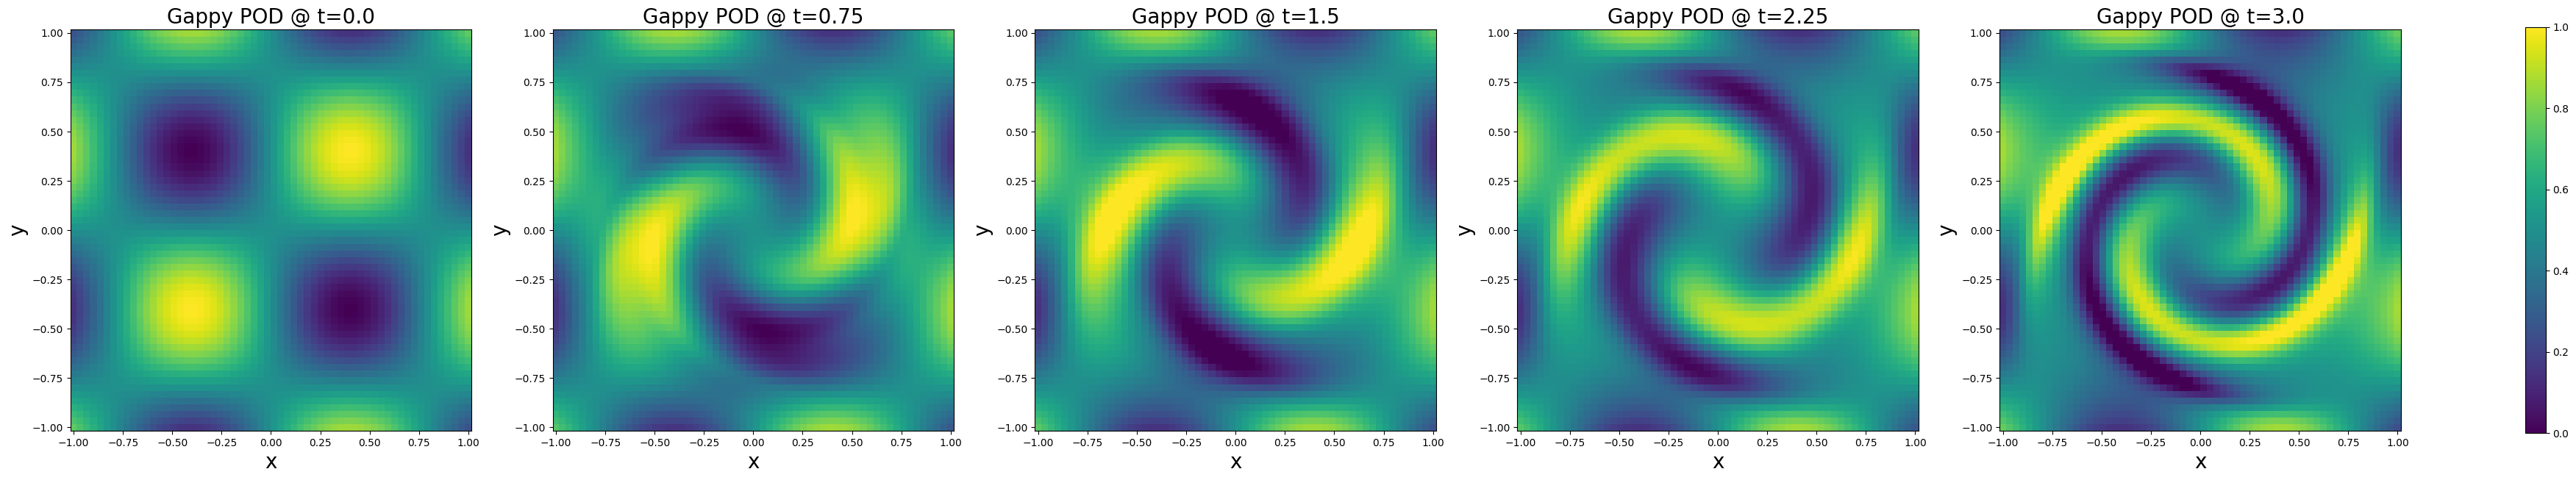

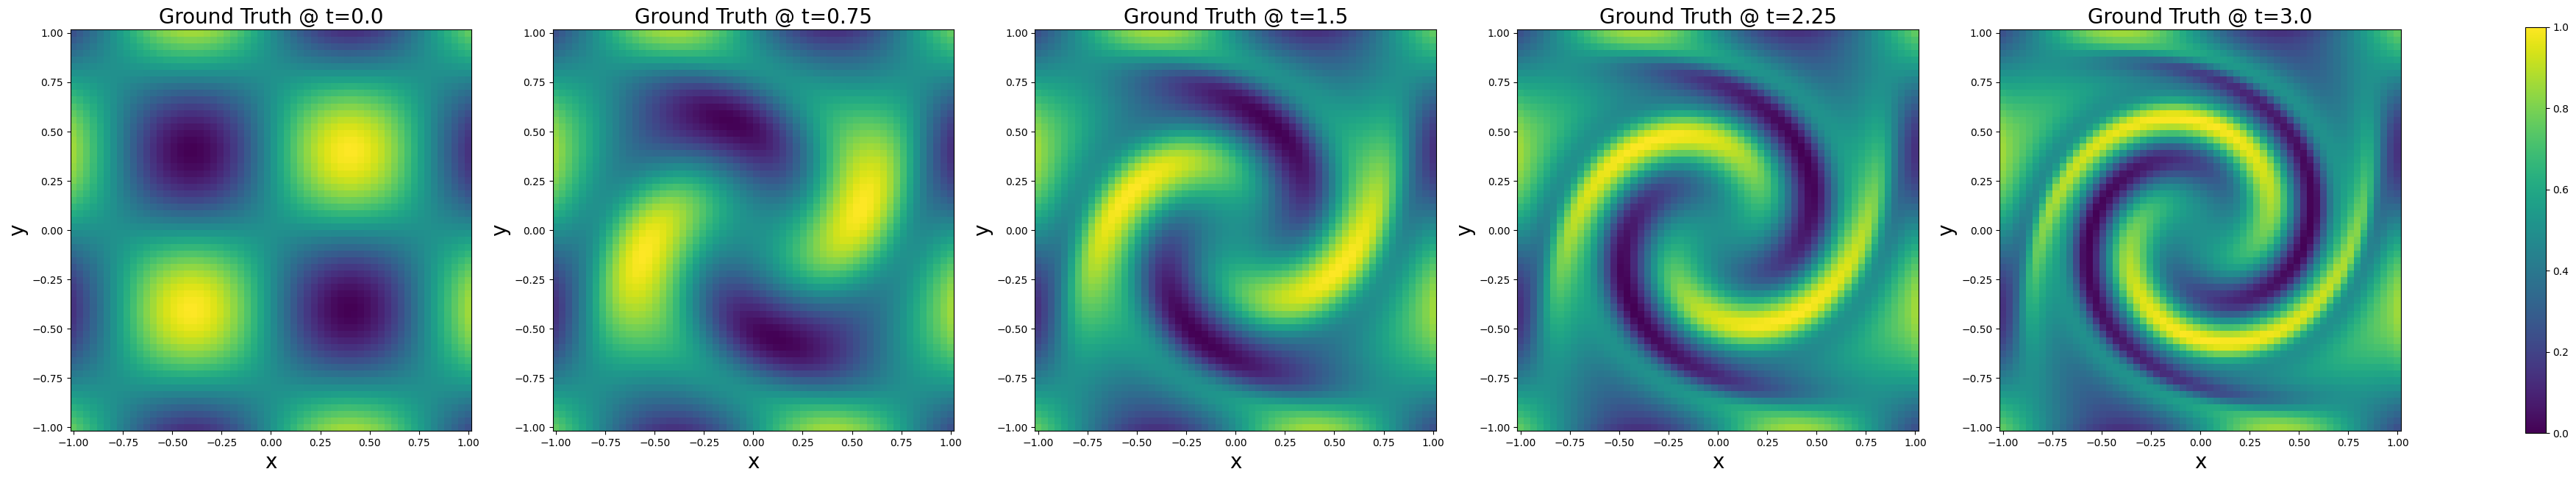

In [95]:
# figure rel.err vs at given param and POD basis
i=3;j=-1
POD_basis=num_basis[i]                 
param=FOM_parameters[j]

u_gappyPOD=results['solution'][i,j]

ex = np.load('./advection_data/ex9_interp_{}.npz'.format(param), allow_pickle = True)
ex = ex.f.arr_0
u_full = ex.reshape(nt+1,-1)

plt.figure(figsize=(10,5))
plt.plot(np.arange(1,nt+1),results['rel_err'][i,j,1:].flatten())
plt.xlabel('Time Step')
plt.ylabel('Rel. Err.')
plt.title("POD basis: {} Param: {}".format(POD_basis,param))
plt.show()

# plot original data
vmin=0; vmax=1
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(35,7),layout='constrained')
for i in range(len(axes)):
    ax=axes[i]
    pcm = ax.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), u_gappyPOD[int(nt/4)*i].reshape(ny,nx),vmin=vmin,vmax=vmax)
    ax.axis('square')
    ax.set_xlabel('x',fontsize=20)
    ax.set_ylabel('y',fontsize=20)
    ax.set_title('Gappy POD @ t={}'.format(int(nt/4)*i*dt),fontsize=20)

fig.colorbar(pcm, ax=axes.tolist(),shrink=0.8)
# plt.savefig("./advection_result/ex9_POD_{}_DEIM_SOL.png".format(POD_basis))

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(35,7),layout='constrained')
for i in range(len(axes)):
    ax=axes[i]
    pcm = ax.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), u_full[int(nt/4)*i].reshape(ny,nx),vmin=vmin,vmax=vmax)
    ax.axis('square')
    ax.set_xlabel('x',fontsize=20)
    ax.set_ylabel('y',fontsize=20)
    ax.set_title('Ground Truth @ t={}'.format(int(nt/4)*i*dt),fontsize=20)

fig.colorbar(pcm, ax=axes.tolist(),shrink=0.8)
# plt.savefig("./advection_result/ex9_ground_truth.png")